In [191]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [207]:
import numpy as np
from kmodes import kprototypes
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from datetime import date
from abc import abstractmethod
import os


def set_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))


def set_sex(sex_str):
    if sex_str == 'female':
        return 0
    elif sex_str == 'male':
        return 1


def next_month(year, month):
    if month == 12:
        return year+1, 1
    else:
        return year, month+1

    
def get_activity_level(steps):
    if steps < 5000:
        return 0
    elif (steps >= 5000) and (steps < 10000):
        return 1
    elif steps >= 10000:
        return 2
    #elif (steps >= 10000) and (steps < 15000):
    #    return 3
    #elif (steps >= 10000) and (steps < 15000):
    #    return 4    
    #elif (steps >= 15000):
    #    return 5    

    
def visualize_bmi_steps(df_bmi_steps, n_months):
    x_ticks = [m for m in range(1,n_months+1)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(x_ticks, df_bmi_steps['bmi'], 'b-')
    ax1.set_xlabel('month')

    ax1.set_ylabel('bmi', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(x_ticks, df_bmi_steps['steps'], 'g-')
    ax2.set_ylabel('steps', color='g')
    ax2.tick_params('y', colors='g')

    fig.tight_layout()
    plt.show()

class UsersClusters:

    def __init__(self, num_clusters, clustering_fields, data_dir='.'):
        with open(os.path.join(data_dir, 'bmi_steps.pickle'), 'rb') as f:
            self.bmi_steps = pd.DataFrame(pickle.load(f))
        with open(os.path.join(data_dir,'users_filter.pickle'), 'rb') as f:
            self.users = pd.DataFrame(pickle.load(f))

            self.users['age'] = self.users['birthday'].apply(lambda x: set_age(x))
            self.users['sex'] = self.users['sex'].apply(lambda x: set_sex(x))

            self.users_data = pd.merge(self.users, 
                                       self.user_entries_per_month(), on='user_id')
            
            self.rescale_info = {
                'age': {
                    'min': min(self.users_data['age']),
                    'range': max(self.users_data['age']) - min(self.users_data['age'])
                },
                'bmi': {
                    'min': min(self.users_data['bmi']),
                    'range': max(self.users_data['bmi']) - min(self.users_data['bmi'])
                },
                'activity_level': {
                    'min': min(self.users_data['activity_level']),
                    'range': max(
                        self.users_data['activity_level']) - min(
                        self.users_data['activity_level'])
                },
            }
            
            self.clustering_fields = clustering_fields
            self.cluster_data = np.array(self.users_data[clustering_fields])
            for c in range(len(clustering_fields)):
                self.cluster_data[:,c] = self.rescale_data(
                    self.cluster_data[:,c], clustering_fields[c] )
         
            print(self.cluster_data)
            
            self.clusters = self.find_clusters(num_clusters)
            
            self.centers = np.copy(self.clusters.cluster_centers_)
            for i in range(len(self.clustering_fields)):
                self.centers[:,i] = self.scale_data(self.centers[:,i], 
                                                    self.clustering_fields[i])


    @abstractmethod
    def find_clusters(self, num_clusters):
        return NotImplemented

    @abstractmethod
    def get_cluster(self, clustering_fields_values):
        return NotImplemented
    
    def get_centers(self):
        return self.centers
    
    def rescale_data(self, data_value, data_type):
        if data_type == 'sex':
            return data_value
        return (data_value - self.rescale_info[data_type]['min']) / (
            self.rescale_info[data_type]['range'])
    
    def scale_data(self, data_value, data_type):
        if data_type == 'sex':
            return data_value
        return (data_value * self.rescale_info[data_type]['range']) + (
            self.rescale_info[data_type]['min'])
    
    def user_entries_per_month(self):
        bmi_steps_month = self.bmi_steps.groupby(
            ['user_id', 'year', 'month'])['bmi', 'steps'].agg('mean')
        bmi_steps_month['activity_level'] = bmi_steps_month['steps'].apply(
            lambda x: get_activity_level(x))
        return bmi_steps_month.reset_index()

    def get_cluster_members(self, cluster_label):
        idx = [i for i, x in enumerate(self.clusters.labels_) if x == cluster_label]
        return self.users_data.iloc[idx]

    def recommender_user_sequence(self, clustering_fields_values, n_months):
        cluster_label = self.get_cluster(clustering_fields_values)
        cluster_members = self.get_cluster_members(cluster_label)
        return best_cluster_sequence(cluster_members, n_months)


class KMeansUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = KMeans(n_clusters=num_clusters)
        return clusters.fit(self.cluster_data)

    def get_cluster(self, clustering_fields_values):
        rescaled_data = [self.rescale_data(clustering_fields_values[k], 
                                k) for k in clustering_fields_values.keys()]
        print(rescaled_data)
        return self.clusters.predict(np.array(
            [rescaled_data]))[0]



def is_ordered_sequence(seq):
    for i in range(len(seq) - 1):
        if (seq[i + 1]['year'], seq[i + 1]['month']) != next_month(
                seq[i]['year'], seq[i]['month']):
            return False
    return True


def get_user_sequences(user_entries, n_months):
    user_entries.sort_values(['year', 'month'])
    user_sequences = []
    for i in range(len(user_entries)-n_months):
        seq = []
        for j in range(n_months):
            seq.append(user_entries.iloc[i+j])
        if is_ordered_sequence(seq):
            user_sequences.append(seq)
    return user_sequences


def best_user_sequence(user_entries, n_months):
    user_sequences = get_user_sequences(user_entries, n_months)
    first = True
    best_seq = None
    best_corr = None
    for seq in user_sequences:
        df = pd.DataFrame(seq)
        if (df.bmi.std() < 0.01) or (df.steps.std() < 0.01):
            continue
        cur_corr = df[['bmi','steps']].corr()['bmi']['steps']
        if first:
            first=False
            best_seq = seq
            best_corr = cur_corr
        elif cur_corr < best_corr:
            best_seq = seq
            best_corr = cur_corr
    return best_seq, best_corr


def best_cluster_sequence(cluster_members, n_months):
    best_cluster_seq = None
    best_cluster_corr = None
    first = True
    for user_id in set(cluster_members.user_id):
        user_entries = cluster_members[cluster_members.user_id == user_id]
        best_seq, best_corr = best_user_sequence(user_entries, n_months)
        if best_corr is None:
            continue
        if first:
            first = False
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
        elif best_corr < best_cluster_corr:
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
    return best_cluster_seq, best_cluster_corr


if __name__ == "__main__":
    # Create Clusters
    number_of_clusters = 12
    clustering_fields = ['age', 'bmi', 'activity_level']
    users_clusters = KMeansUsersClusters(number_of_clusters, 
                                         clustering_fields, 
                                         data_dir='../data/filtered')

[[ 0.8125      0.25457916  0.5       ]
 [ 0.8125      0.25729765  0.5       ]
 [ 0.0125      0.32879644  0.5       ]
 ..., 
 [ 0.5125      0.28345543  1.        ]
 [ 0.5125      0.28345543  1.        ]
 [ 0.45        0.36507573  0.        ]]


# Visualize clusters

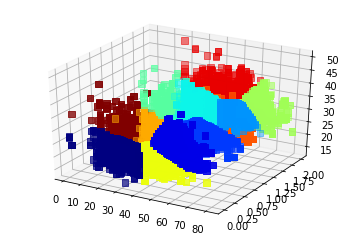

In [208]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

age = []
sex = []
bmi = []
activity_level = []
cluster = []
for i in range(number_of_clusters):
    members = users_clusters.get_cluster_members(i)
    age.extend(members.age)
    sex.extend(members.sex)
    bmi.extend(members.bmi)
    activity_level.extend(members.activity_level)
    cluster.extend([i] * len(members))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(age,activity_level,bmi, marker="s", c=cluster, s=40, cmap="jet_r")
# ax.scatter(age,bmi,sex, marker="s", c=cluster, s=40)
plt.show()


In [225]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(users_clusters.cluster_data)
pca_2d = pca.transform(users_clusters.cluster_data)
print(pca_2d)

[[ 0.08138245 -0.19691209]
 [ 0.08150238 -0.1978502 ]
 [ 0.08994229  0.52829799]
 ..., 
 [-0.41486379  0.07016511]
 [-0.41486379  0.07016511]
 [ 0.58815449  0.10968895]]


# Visualize Graphs for each cluster

0
657
[  3.81354642e+01   3.48846322e+01   9.32587341e-15]
[  4.64193303e-01   5.88942668e-01   4.66293670e-15]


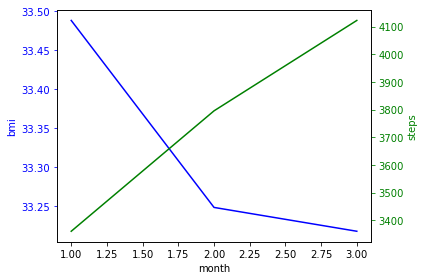

1
1200
[ 43.025       32.91327916   2.        ]
[ 0.5253125   0.53376381  1.        ]


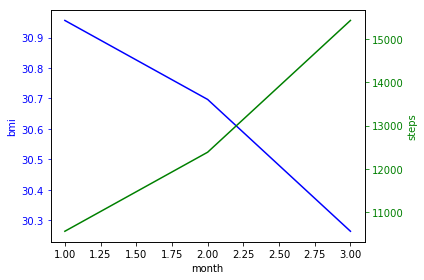

2
611
[ 60.97217676  32.81906975   1.        ]
[ 0.74965221  0.53112685  0.5       ]


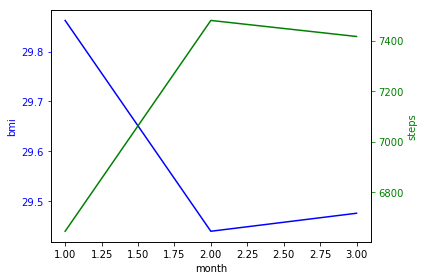

3
878
[ 32.29840547  24.66357893   1.        ]
[ 0.39123007  0.30285181  0.5       ]


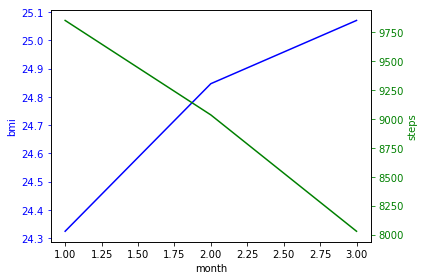

4
1025
[  4.98044747e+01   2.54928423e+01   2.02060590e-14]
[  6.10055934e-01   3.26063179e-01   1.01030295e-14]


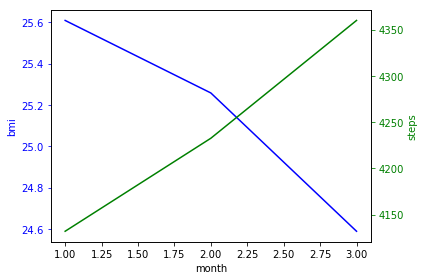

5
1139
[ 61.56014047  27.93114694   2.        ]
[ 0.75700176  0.39431218  1.        ]


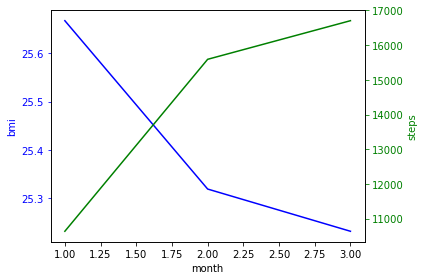

6
605
[ 39.28595041  34.19550562   1.        ]
[ 0.47857438  0.56965377  0.5       ]


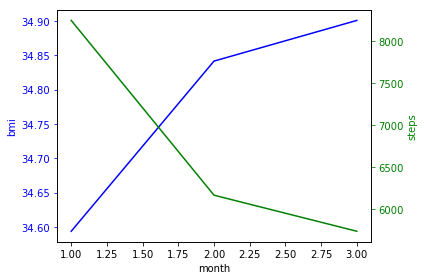

7
1534
[ 30.48696219  24.74825979   2.        ]
[ 0.36858703  0.30522206  1.        ]


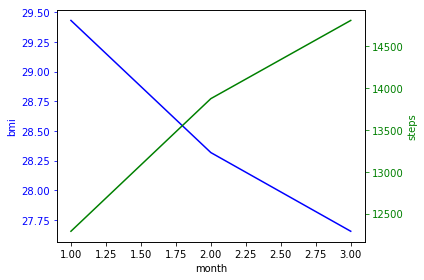

8
1761
[ 47.9721749   24.64205294   2.        ]
[ 0.58715219  0.30224929  1.        ]


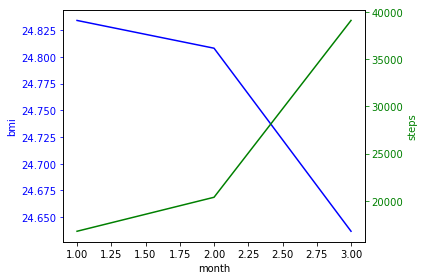

9
1308
[ 52.80122324  26.02246429   1.        ]
[ 0.64751529  0.34088749  0.5       ]


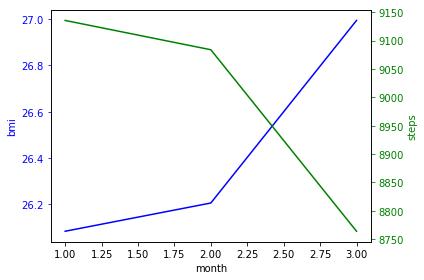

10
724
[  6.05096685e+01   3.18084720e+01   1.22124533e-14]
[  7.43870856e-01   5.02839867e-01   6.10622664e-15]


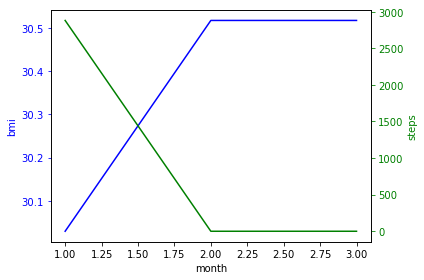

11
1007
[  3.03187251e+01   2.48007100e+01   1.97619698e-14]
[  3.66484064e-01   3.06690154e-01   9.88098492e-15]


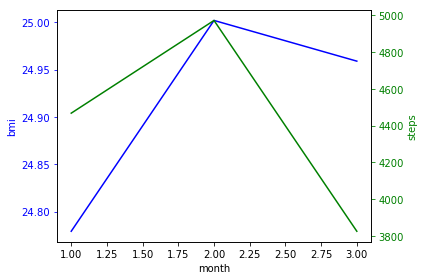

In [209]:
n_months = 3
for i in range(number_of_clusters):
    cluster_members = users_clusters.get_cluster_members(i)
    print(i)
    print(len(cluster_members))
    print(users_clusters.get_centers()[i])
    print(users_clusters.clusters.cluster_centers_[i])
    best_seq, corr = best_cluster_sequence(cluster_members, n_months)
    visualize_bmi_steps(pd.DataFrame(best_seq)[['bmi','steps']], n_months)
    


# Test on user data

In [195]:
user_id = '2a786a87-f00b-461a-90cd-c1a7a9a06f2e'
year = 2016
month = 2
n_months = 6

user_data = users_clusters.users_data[
    (users_clusters.users_data.user_id == user_id) &
    (users_clusters.users_data.year == year) &
    (users_clusters.users_data.month == month)]

clustering_fields_values = {
    #'sex': user_data['sex'].values[0]
    'age': user_data['age'].values[0],
    'bmi': user_data['bmi'].values[0],
    'activity_level': user_data['activity_level'].values[0]
}
print('User data:', clustering_fields_values)

recommended_seq, corr = users_clusters.recommender_user_sequence(clustering_fields_values, n_months)
print('Cluster data (age,bmi,activity_level):', 
      recommended_seq[0]['age'], recommended_seq[0]['bmi'], recommended_seq[0]['activity_level'])

visualize_bmi_steps(pd.DataFrame(recommended_seq)[['bmi','steps']], n_months)

User data: {'age': 44, 'bmi': 25.94240673585124, 'activity_level': 1}


TypeError: 'NoneType' object is not subscriptable

# Test on given input data

Input data: {'age': 37, 'bmi': 25, 'activity_level': 2}
[0.45000000000000001, 0.31226835183155743, 1.0]
Cluster data (age,bmi,activity_level): 34 29.4296875 2
[0.45000000000000001, 0.31226835183155743, 1.0]


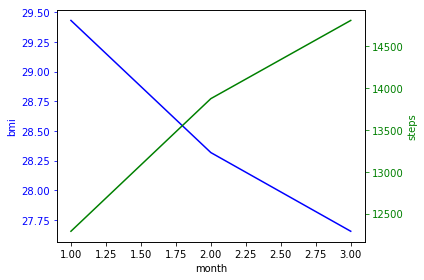

7


In [222]:
clustering_fields_values = {
    #'sex': 1,
    'age': 37,
    'bmi': 25,
    'activity_level': 2
}
print('Input data:', clustering_fields_values)
user_steps = 12000
recommended_seq, corr = users_clusters.recommender_user_sequence(
    clustering_fields_values, n_months)
print('Cluster data (age,bmi,activity_level):', 
      recommended_seq[0]['age'], recommended_seq[0]['bmi'],
     recommended_seq[0]['activity_level'])

cluster = users_clusters.get_cluster(clustering_fields_values)
visualize_bmi_steps(pd.DataFrame(recommended_seq)[['bmi','steps']], n_months)
print(cluster)

**Cluster info: **
[0.45000000000000001, 0.31226835183155743, 1.0]
[ 30.48696219  24.74825979   2.        ]
* Bmi


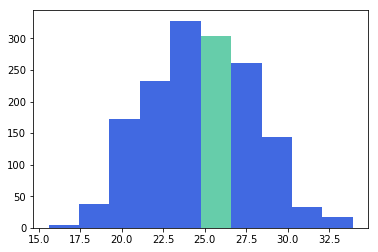

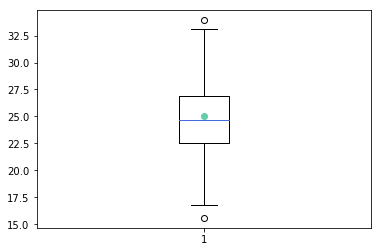

* Activity level


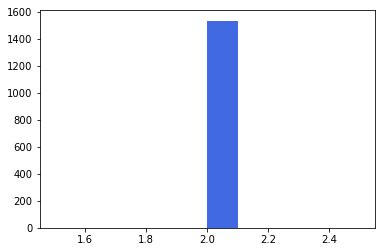

* Steps


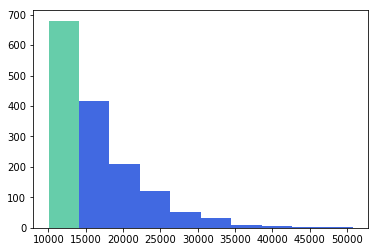

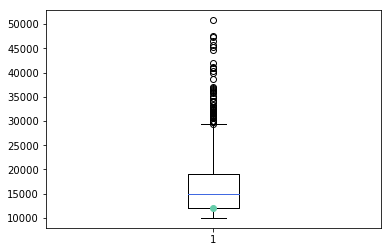

* Age


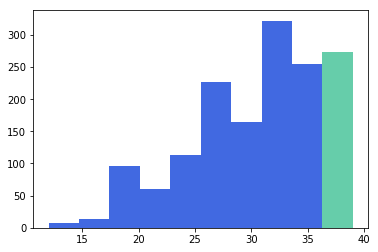

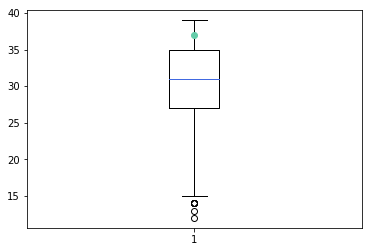

In [223]:
print('**Cluster info: **')
cluster = users_clusters.get_cluster(clustering_fields_values)
cluster_members = users_clusters.get_cluster_members(cluster)
print(users_clusters.get_centers()[cluster])
print('* Bmi')
n, bins, patches = plt.hist(
    list(cluster_members['bmi'].values), bins = 10, color = "royalblue")
user_bin = min(range(len(bins)), 
               key=lambda i: abs(bins[i]-clustering_fields_values['bmi']))
patches[user_bin].set_fc('mediumaquamarine')
medianprops = dict(color='royalblue')
plt.show()
plt.boxplot(cluster_members['bmi'].values, 0, medianprops=medianprops)
# plt.axhline(y=28)
x = np.random.normal(1, 0.04, size=1)
plt.plot([1], clustering_fields_values['bmi'], 'o', c='mediumaquamarine')
plt.show()

print('* Activity level')
n, bins, patches = plt.hist(
    list(cluster_members['activity_level'].values), bins = 10, color = "royalblue")
plt.show()

print('* Steps')
n, bins, patches = plt.hist(
    list(cluster_members['steps'].values), bins = 10, color = "royalblue")
user_bin = min(range(len(bins)), 
               key=lambda i: abs(bins[i]-user_steps))
patches[user_bin].set_fc('mediumaquamarine')
plt.show()
plt.boxplot(cluster_members['steps'].values, 0., medianprops=medianprops )
plt.plot([1], user_steps, 'o', c='mediumaquamarine')
plt.show()

print('* Age')
n, bins, patches = plt.hist(
    list(cluster_members['age'].values), bins = 10, color = "royalblue")
user_bin = min(range(len(bins)), 
               key=lambda i: abs(bins[i]-clustering_fields_values['age']))
patches[user_bin].set_fc('mediumaquamarine')
plt.show()
plt.boxplot(cluster_members['age'].values, 0, medianprops=medianprops)
plt.plot([1], clustering_fields_values['age'], 'o', c='mediumaquamarine')
plt.show()

In [48]:
cluster_members

,birthday,height,sex,user_id,birthyear,age,year,month,bmi,steps,activity_level
1,1950-11-12 01:00:00,174.0,1,000d49c2-9b5d-4718-94bc-78b90ed48290,1950,66,2016,11,23.036084,6630.857143,1
20,1967-09-28 00:00:00,177.0,0,012b7f05-8201-4758-9325-755a7a684c93,1967,50,2014,1,26.741677,6332.000000,1
32,1963-06-19 00:00:00,177.0,0,0162db16-1d66-408c-84bc-0ff571ad9e3b,1963,54,2016,1,27.642121,5921.333333,1
39,1971-04-23 00:00:00,189.0,1,018fb8fa-43ec-4141-acc0-d0b9441dd2f1,1971,46,2015,8,28.498642,3375.000000,0
40,1971-04-23 00:00:00,189.0,1,018fb8fa-43ec-4141-acc0-d0b9441dd2f1,1971,46,2015,10,28.498642,5275.000000,1
56,1970-10-06 01:00:00,167.0,0,02411783-fa3f-498a-aa7f-d6b9601c0298,1970,47,2016,10,18.980004,0.000000,0
64,1974-03-05 01:00:00,190.0,1,0286419d-16db-433b-8426-2d8f666f3e67,1974,43,2017,3,28.116343,0.000000,0
81,1968-04-18 00:00:00,184.0,1,02b06812-5b71-4d26-81a6-a401ef969d9d,1968,49,2015,11,30.788487,6724.250000,1
100,1965-01-05 01:00:00,182.0,1,039c6def-803f-46b5-882d-5abff3c52af2,1965,52,2016,2,26.627219,0.000000,0
103,1957-03-13 01:00:00,168.0,0,03f785a5-a4dc-4ad3-ac1d-ab287b36b455,1957,60,2016,10,23.579223,0.000000,0
